In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

data = pd.read_excel("Tiruchirappalli_1950_2050.xlsx")
data.head()

,...1,month,tempave,tempmax,tempmin,relhum,solarrad,soilmoist,prcp,PET,SPEI,SPI
0,12,1951-1-01,22.618707,31.703943,15.444757,60.777390,-3.442093,380.614044,7.476133,152.874706,0.0,0.0
1,13,1951-2-01,25.324579,34.803644,18.682092,54.280716,30.918823,377.758148,0.010876,160.920739,0.0,0.0
2,14,1951-3-01,26.421045,37.109521,20.970483,44.732533,65.733597,376.798584,0.146999,200.996165,0.0,0.0
3,15,1951-4-01,29.930139,37.120752,22.606378,50.701565,84.712952,376.869537,1.405223,194.130918,0.0,0.0
4,16,1951-5-01,30.761407,35.729089,24.422998,51.242672,115.409958,382.826569,2.518414,176.698768,0.0,0.0


In [ ]:
date_column = "month"
pred_column = "tempmax"
data[date_column] = pd.to_datetime(data[date_column])
data[date_column].max() - data[date_column].min()

Timedelta('36509 days 00:00:00')

<Axes: >

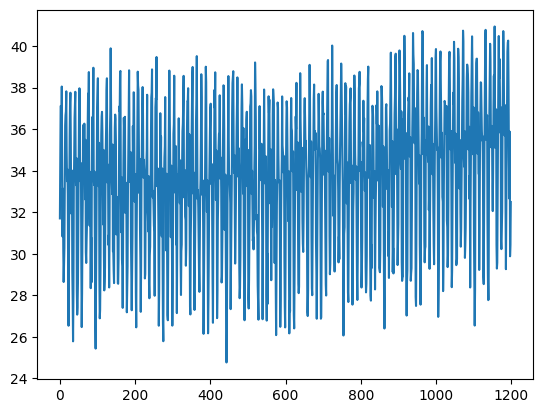

In [ ]:
maxt = data['tempmax']
maxt.plot()

In [ ]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+24]]
    X.append(row)
    label = df_as_np[i+24]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 24
X, y = df_to_X_y(maxt, WINDOW_SIZE)
X.shape, y.shape

((1176, 24, 1), (1176,))

In [ ]:
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 24, 1), (780,), (120, 24, 1), (120,), (276, 24, 1), (276,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((24,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
25/25 [==============================] - 0s 20ms/step - loss: 2.0777 - root_mean_squared_error: 1.4414 - val_loss: 2.1559 - val_root_mean_squared_error: 1.4683
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 2.0257 - root_mean_squared_error: 1.4233 - val_loss: 2.4688 - val_root_mean_squared_error: 1.5712
Epoch 3/20
25/25 [==============================] - 0s 15ms/step - loss: 1.8723 - root_mean_squared_error: 1.3683 - val_loss: 2.1354 - val_root_mean_squared_error: 1.4613
Epoch 4/20
25/25 [==============================] - 0s 16ms/step - loss: 1.8314 - root_mean_squared_error: 1.3533 - val_loss: 2.1152 - val_root_mean_squared_error: 1.4544
Epoch 5/20
25/25 [==============================] - 0s 16ms/step - loss: 1.7561 - root_mean_squared_error: 1.3252 - val_loss: 2.1333 - val_root_mean_squared_error: 1.4606
Epoch 6/20
25/25 [==============================] - 0s 15ms/step - loss: 2.2593 - root_mean_squared_error: 1.5031 - val_loss: 3.3972 - val_root_m

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

25/25 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,30.287910,29.768732
1,33.369259,33.059442
2,35.551502,35.677911
3,37.254253,37.296381
4,37.781521,37.757532
...,...,...
775,33.134747,33.986200
776,34.376873,34.425409
777,30.755476,30.344476
778,28.178530,28.374933


In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 0s 9ms/step


,Val Predictions,Actuals
0,31.694221,30.761957
1,33.735279,35.390863
2,36.428936,35.122217
3,37.406353,37.371088
4,38.158585,35.881006
...,...,...
115,33.630238,34.558099
116,34.471966,35.816766
117,32.356586,28.670892
118,28.351095,27.025201


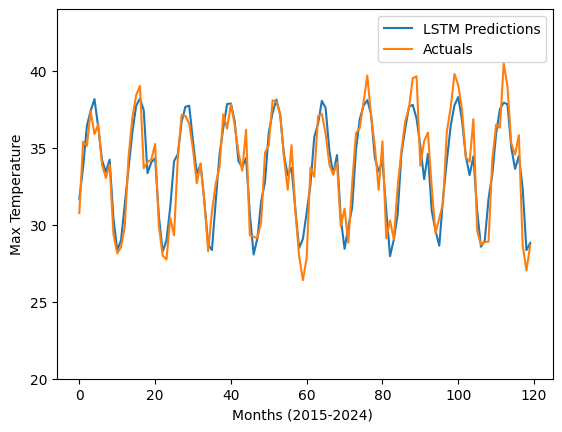

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Max Temperature')
plt.ylim(20, 44)
plt.legend()
plt.show()

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 6ms/step


,Test Predictions,Actuals
0,31.351267,29.198328
1,33.483089,34.116754
2,35.979130,36.706812
3,37.765228,37.524530
4,38.180737,37.348932
...,...,...
271,33.697865,32.660089
272,34.340145,35.885828
273,30.903997,29.879999
274,28.621584,30.446069


In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 5ms/step


,Test Predictions,Actuals
0,31.351267,29.198328
1,33.483089,34.116754
2,35.979130,36.706812
3,37.765228,37.524530
4,38.180737,37.348932
...,...,...
271,33.697865,32.660089
272,34.340145,35.885828
273,30.903997,29.879999
274,28.621584,30.446069


In [ ]:
max_temp_list = val_predictions
max_temp_list = max_temp_list.tolist()
max_temp_list.extend(test_predictions)

print(len(max_temp_list))
max_temp_list

396


[31.69422149658203,
 33.73527908325195,
 36.42893600463867,
 37.40635299682617,
 38.15858459472656,
 36.31772994995117,
 34.18718338012695,
 33.42148208618164,
 34.227691650390625,
 30.4355525970459,
 28.35055923461914,
 28.973567962646484,
 31.328886032104492,
 33.679969787597656,
 36.012847900390625,
 37.72980880737305,
 38.194637298583984,
 37.430477142333984,
 33.33957290649414,
 34.05472183227539,
 34.3228759765625,
 30.538814544677734,
 28.260229110717773,
 28.980127334594727,
 31.152551651000977,
 34.12604904174805,
 34.583133697509766,
 36.682167053222656,
 37.66022872924805,
 37.72877883911133,
 35.421810150146484,
 33.3320426940918,
 33.91238021850586,
 31.514554977416992,
 28.714914321899414,
 28.3559513092041,
 31.527463912963867,
 34.55768966674805,
 36.30092239379883,
 37.83842086791992,
 37.873260498046875,
 36.72480010986328,
 34.12820816040039,
 33.71632385253906,
 34.32846450805664,
 30.700098037719727,
 28.067623138427734,
 29.12815284729004,
 31.534629821777344,
 32

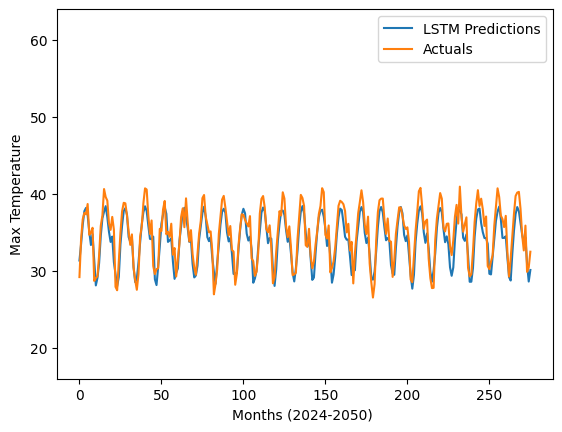

In [ ]:
plt.plot(test_results['Test Predictions'][:300], label='LSTM Predictions')
plt.plot(test_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2024-2050) ')
plt.ylabel('Max Temperature')
plt.ylim(16, 64)
plt.legend()
plt.show()


<Axes: >

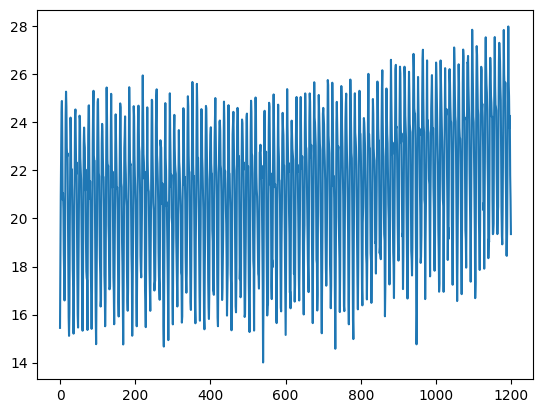

In [ ]:
mint = data['tempmin']
mint.plot()

In [ ]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+24]]
    X.append(row)
    label = df_as_np[i+24]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 24
X, y = df_to_X_y(mint, WINDOW_SIZE)
X.shape, y.shape
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 24, 1), (780,), (120, 24, 1), (120,), (276, 24, 1), (276,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(InputLayer((24,1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
25/25 [==============================] - 8s 180ms/step - loss: 7.9128 - root_mean_squared_error: 2.8130 - val_loss: 7.0627 - val_root_mean_squared_error: 2.6576
Epoch 2/20
25/25 [==============================] - 4s 183ms/step - loss: 5.3206 - root_mean_squared_error: 2.3066 - val_loss: 4.5981 - val_root_mean_squared_error: 2.1443
Epoch 3/20
25/25 [==============================] - 5s 208ms/step - loss: 3.5217 - root_mean_squared_error: 1.8766 - val_loss: 3.9492 - val_root_mean_squared_error: 1.9873
Epoch 4/20
25/25 [==============================] - 4s 158ms/step - loss: 2.4378 - root_mean_squared_error: 1.5614 - val_loss: 2.4226 - val_root_mean_squared_error: 1.5565
Epoch 5/20
25/25 [==============================] - 5s 195ms/step - loss: 1.9347 - root_mean_squared_error: 1.3909 - val_loss: 1.6574 - val_root_mean_squared_error: 1.2874
Epoch 6/20
25/25 [==============================] - 4s 158ms/step - loss: 1.3735 - root_mean_squared_error: 1.1720 - val_loss: 0.9739 - val_

In [ ]:
val_predictions = model2.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results
test_predictions = model2.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 6ms/step


,Test Predictions,Actuals
0,16.621523,16.665643
1,17.547468,17.892786
2,20.239346,20.589655
3,23.064838,24.545435
4,25.307278,26.108514
...,...,...
271,23.391781,23.759760
272,22.519121,24.274561
273,22.268301,21.791498
274,20.013697,20.791528


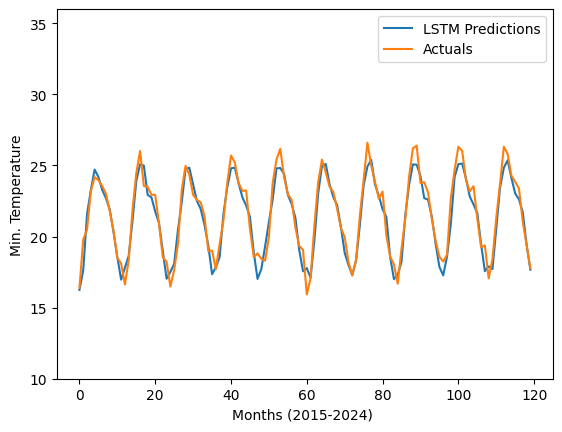

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Min. Temperature')
plt.ylim(10, 36)
plt.legend()
plt.show()

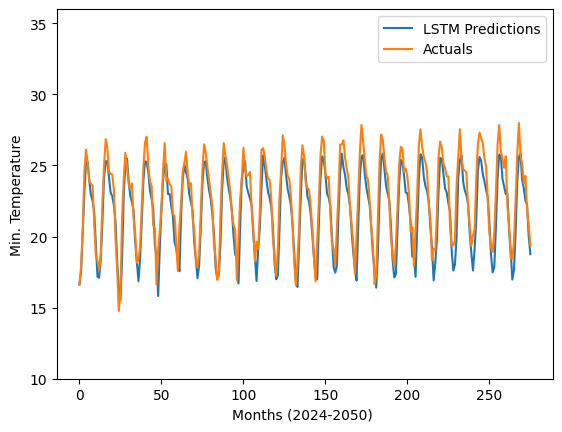

In [ ]:
plt.plot(test_results['Test Predictions'][:300], label='LSTM Predictions')
plt.plot(test_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2024-2050) ')
plt.ylabel('Min. Temperature')
plt.ylim(10, 36)
plt.legend()
plt.show()

In [ ]:
min_temp_list = val_predictions
min_temp_list = min_temp_list.tolist()
min_temp_list.extend(test_predictions)

print(len(min_temp_list))
min_temp_list

396


[16.246997833251953,
 17.633609771728516,
 21.568992614746094,
 23.260011672973633,
 24.713665008544922,
 24.19745635986328,
 23.289196014404297,
 22.69727897644043,
 21.89301872253418,
 20.309900283813477,
 18.558134078979492,
 16.968400955200195,
 17.802841186523438,
 18.65056800842285,
 21.104490280151367,
 23.912227630615234,
 25.095111846923828,
 24.98809051513672,
 22.930221557617188,
 22.76398468017578,
 21.75367546081543,
 20.953693389892578,
 18.964763641357422,
 17.0335750579834,
 17.50904655456543,
 18.095901489257812,
 20.47631072998047,
 22.426115036010742,
 24.738510131835938,
 24.846887588500977,
 23.66020965576172,
 22.508020401000977,
 21.93866729736328,
 20.82537269592285,
 19.385231018066406,
 17.352760314941406,
 17.84002113342285,
 18.565757751464844,
 21.5915470123291,
 23.4464168548584,
 24.800399780273438,
 24.852556228637695,
 23.755247116088867,
 22.76445198059082,
 22.1793155670166,
 21.36992835998535,
 18.892532348632812,
 17.019472122192383,
 17.71481323242

<Axes: >

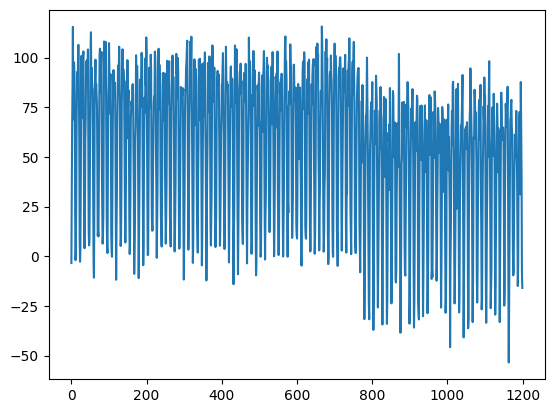

In [ ]:
sr = data['solarrad']
sr.plot()

In [ ]:
def df_to_X_y(df, window_size=12):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+12]]
    X.append(row)
    label = df_as_np[i+12]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 12
X, y = df_to_X_y(sr, WINDOW_SIZE)
X.shape, y.shape
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 12, 1), (780,), (120, 12, 1), (120,), (288, 12, 1), (288,))

In [ ]:
model3 = Sequential()
model3.add(InputLayer((12,1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=[cp])

Epoch 1/40
25/25 [==============================] - 10s 342ms/step - loss: 4070.8159 - root_mean_squared_error: 63.8029 - val_loss: 2376.9773 - val_root_mean_squared_error: 48.7543
Epoch 2/40
25/25 [==============================] - 8s 332ms/step - loss: 3900.0283 - root_mean_squared_error: 62.4502 - val_loss: 2263.3303 - val_root_mean_squared_error: 47.5745
Epoch 3/40
25/25 [==============================] - 4s 161ms/step - loss: 3696.2859 - root_mean_squared_error: 60.7971 - val_loss: 2137.3547 - val_root_mean_squared_error: 46.2315
Epoch 4/40
25/25 [==============================] - 4s 151ms/step - loss: 3486.8625 - root_mean_squared_error: 59.0497 - val_loss: 2005.9948 - val_root_mean_squared_error: 44.7883
Epoch 5/40
25/25 [==============================] - 4s 159ms/step - loss: 3265.8879 - root_mean_squared_error: 57.1479 - val_loss: 1870.2024 - val_root_mean_squared_error: 43.2458
Epoch 6/40
25/25 [==============================] - 5s 223ms/step - loss: 3035.6831 - root_mean_squ

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')
train_predictions = model3.predict(X_train).flatten()
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

25/25 [==============================] - 1s 4ms/step


,Train Predictions,Actuals
0,9.601122,4.276947
1,30.641041,30.925751
2,66.070183,69.745300
3,70.442329,92.638367
4,70.543236,85.074814
...,...,...
775,70.551147,80.564941
776,70.505951,60.507904
777,25.112183,28.163589
778,-0.427948,3.419678


In [ ]:
val_predictions = model3.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 0s 5ms/step


,Val Predictions,Actuals
0,0.141931,-31.741943
1,7.100308,18.164795
2,55.148743,53.812164
3,69.390427,60.662598
4,70.459396,73.642578
...,...,...
115,70.564606,84.108887
116,70.554581,70.944290
117,68.225983,47.348404
118,10.160640,-5.665771


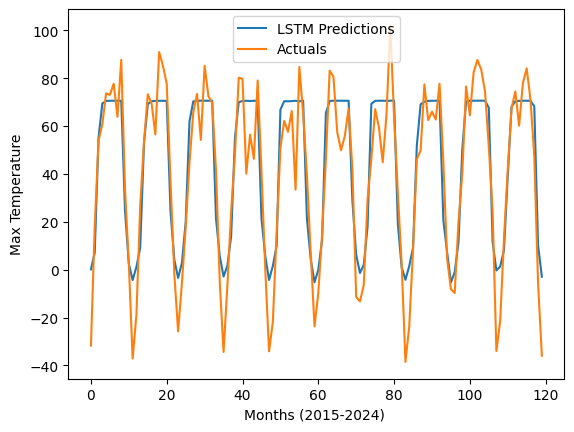

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Max Temperature')
#plt.ylim(20, 44)
plt.legend()
plt.show()

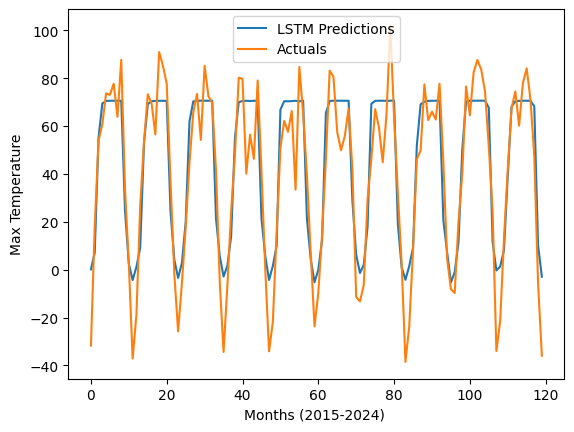

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Max Temperature')
#plt.ylim(20, 44)
plt.legend()
plt.show()

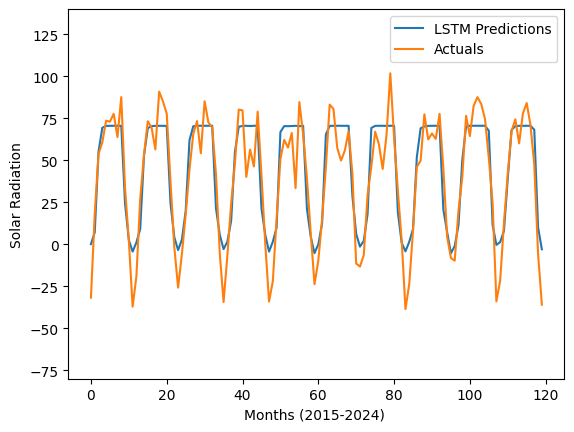

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Solar Radiation')
plt.ylim(-80, 140)
plt.legend()
plt.show()

In [ ]:
test_predictions = model3.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,0.948967,-21.724365
1,7.269743,18.688965
2,46.560535,51.633240
3,68.232971,67.551514
4,70.054688,53.063965
...,...,...
283,70.248764,87.678467
284,70.581299,67.079208
285,70.557549,42.693161
286,8.746098,-7.305908


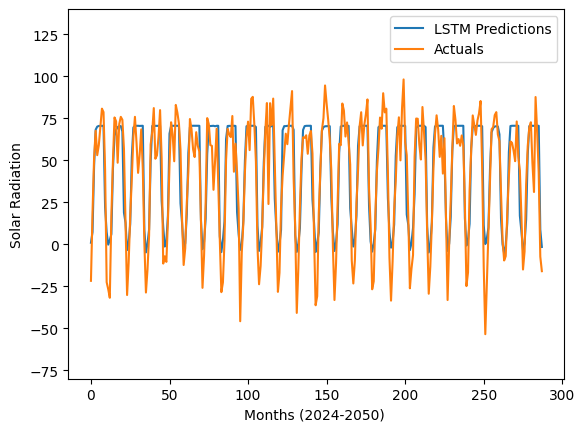

In [ ]:
plt.plot(test_results['Test Predictions'][:300], label='LSTM Predictions')
plt.plot(test_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2024-2050) ')
plt.ylabel('Solar Radiation')
plt.ylim(-80, 140)
plt.legend()
plt.show()

In [ ]:
sr_list = val_predictions
sr_list = sr_list.tolist()
sr_list.extend(test_predictions)

print(len(sr_list))
sr_list

408


[0.14193090796470642,
 7.100308418273926,
 55.14874267578125,
 69.39042663574219,
 70.45939636230469,
 70.5478286743164,
 70.5606689453125,
 70.55668640136719,
 70.52083587646484,
 24.26412582397461,
 2.477339506149292,
 -4.338762283325195,
 1.1476969718933105,
 9.138193130493164,
 52.80116271972656,
 69.15037536621094,
 70.34727478027344,
 70.51234436035156,
 70.53767395019531,
 70.53712463378906,
 70.48619842529297,
 24.281982421875,
 4.193625450134277,
 -3.441793918609619,
 2.7730603218078613,
 19.818286895751953,
 61.84449005126953,
 70.29163360595703,
 70.55062866210938,
 70.57456970214844,
 70.54960632324219,
 70.57981872558594,
 70.57463073730469,
 21.372150421142578,
 5.611143589019775,
 -2.8689112663269043,
 1.569605827331543,
 13.937962532043457,
 54.99506759643555,
 69.98262023925781,
 70.46145629882812,
 70.54612731933594,
 70.44451141357422,
 70.55252075195312,
 70.50904846191406,
 21.355867385864258,
 5.683221340179443,
 -4.309943675994873,
 1.5209791660308838,
 9.9587516

In [ ]:
import numpy as np
minimum_temp = [15.175971984863281,
 14.93736743927002,
 18.761924743652344,
 21.65876579284668,
 21.851024627685547,
 21.239253997802734,
 20.61124038696289,
 19.255329132080078,
 19.20600700378418,
 18.50537109375,
 18.049253463745117,
 16.65020751953125,
 13.781017303466797,
 15.110987663269043,
 20.191579818725586,
 21.68511390686035,
 21.870702743530273,
 20.554567337036133,
 19.65703010559082,
 19.316898345947266,
 18.71853256225586,
 17.611921310424805,
 17.541641235351562,
 16.440814971923828,
 15.88175106048584,
 14.561712265014648,
 18.658296585083008,
 22.04434585571289,
 22.52388572692871,
 21.25831413269043,
 19.96622085571289,
 19.22441291809082,
 18.716289520263672,
 18.657072067260742,
 17.507810592651367,
 15.700098991394043,
 15.265851974487305,
 15.636062622070312,
 17.848115921020508,
 20.76373291015625,
 22.398418426513672,
 21.179290771484375,
 20.051786422729492,
 18.93596839904785,
 18.83534812927246,
 18.178876876831055,
 18.091718673706055,
 16.103178024291992,
 16.055545806884766,
 15.393280029296875,
 18.76830291748047,
 21.154571533203125,
 21.73801612854004,
 21.2990779876709,
 20.29134178161621,
 19.535932540893555,
 19.10630226135254,
 18.790409088134766,
 18.04298210144043,
 15.661035537719727,
 16.2098331451416,
 16.639039993286133,
 18.23586082458496,
 19.819164276123047,
 22.142749786376953,
 21.39374351501465,
 21.16498374938965,
 19.618040084838867,
 19.266855239868164,
 18.01378059387207,
 18.076581954956055,
 16.9295711517334,
 16.5919246673584,
 13.528156280517578,
 16.998537063598633,
 21.261947631835938,
 22.526737213134766,
 21.41790771484375,
 20.216699600219727,
 19.308218002319336,
 18.83832550048828,
 18.248899459838867,
 17.77823257446289,
 16.798097610473633,
 15.790757179260254,
 15.325033187866211,
 18.090173721313477,
 21.699016571044922,
 21.710451126098633,
 21.476049423217773,
 20.31536865234375,
 19.909351348876953,
 18.980314254760742,
 18.811552047729492,
 17.602075576782227,
 15.727067947387695,
 15.341498374938965,
 15.61589241027832,
 19.991844177246094,
 21.933855056762695,
 21.73786735534668,
 21.501588821411133,
 21.190025329589844,
 19.7556209564209,
 19.461214065551758,
 18.83687400817871,
 18.074800491333008,
 17.073253631591797,
 16.08526039123535,
 15.855340003967285,
 17.522289276123047,
 21.407682418823242,
 22.151351928710938,
 21.72295379638672,
 20.962526321411133,
 19.80413246154785,
 19.279930114746094,
 19.40020751953125,
 18.35731315612793,
 17.219614028930664,
 16.94122,
 14.791619,
 17.05871,
 20.377167,
 22.144947,
 21.805742,
 20.857756,
 20.055399,
 19.572676,
 19.140652,
 18.1776,
 17.146063,
 15.268705,
 14.746361,
 18.32963,
 21.49124,
 22.493872,
 21.251368,
 20.629082,
 19.661877,
 19.412493,
 19.513578,
 18.152449,
 16.137983,
 16.096483,
 15.559121,
 18.395012,
 21.723145,
 22.16294,
 21.901394,
 20.966358,
 20.268974,
 19.811327,
 19.711195,
 19.401394,
 17.259829,
 14.590288,
 13.379749,
 17.450428,
 21.962942,
 22.848526,
 21.428513,
 20.326815,
 19.545414,
 19.455187,
 19.507765,
 18.635744,
 17.384806,
 14.996733,
 16.375183,
 18.432196,
 21.444647,
 21.929882,
 22.242167,
 21.594482,
 20.444086,
 19.39417,
 19.582289,
 18.101406,
 18.424135,
 14.370399,
 16.81422,
 19.622702,
 21.20851,
 21.361301,
 21.41935,
 20.029486,
 19.663439,
 19.554611,
 19.538555,
 18.86862,
 18.798431,
 17.008083,
 15.280375,
 18.594173,
 20.388453,
 21.796732,
 20.776726,
 21.007807,
 20.12394,
 19.566244,
 19.221035,
 18.285456,
 17.634762,
 15.143573,
 15.317846,
 18.644106,
 21.720709,
 22.261438,
 22.129509,
 20.955042,
 20.642775,
 19.981825,
 19.172903,
 19.108252,
 16.667728,
 15.471907,
 14.8862705,
 17.005083,
 21.738,
 22.74452,
 21.673738,
 20.860947,
 20.228525,
 20.01394,
 19.425163,
 18.504633,
 18.460398,
 17.985672,
 14.229223,
 18.030455,
 21.0953,
 21.256102,
 21.27936,
 20.410023,
 19.90679,
 19.85481,
 20.01248,
 19.13487,
 18.053108,
 15.958378,
 17.627382,
 17.52029,
 20.537365,
 22.026638,
 21.655575,
 20.75976,
 20.302618,
 19.88151,
 19.784887,
 18.866217,
 17.474102,
 15.753474,
 14.656482,
 18.344545,
 22.010738,
 22.280619,
 22.24307,
 21.484055,
 20.369476,
 20.043829,
 19.592339,
 19.21811,
 18.206959,
 15.254521,
 14.299608,
 17.870966,
 21.392475,
 22.890533,
 21.71487,
 20.926985,
 19.953728,
 19.672094,
 19.340506,
 18.746485,
 17.976446,
 15.404876,
 14.512136,
 18.680834,
 22.254244,
 22.849379,
 22.276297,
 21.542374,
 20.352869,
 19.975365,
 19.606438,
 18.67762,
 16.967516,
 15.990138,
 15.479349,
 19.357021,
 22.007637,
 22.556362,
 22.138384,
 21.531467,
 20.876251,
 20.154272,
 19.643602,
 18.684126,
 18.723269,
 16.596815,
 15.320961,
 18.598972,
 21.780218,
 22.109316,
 22.07033,
 21.526678,
 20.765833,
 19.945158,
 19.816656,
 19.473093,
 18.043037,
 16.328833,
 14.238381,
 16.158747,
 21.05897,
 23.10857,
 22.009092,
 21.346548,
 20.782478,
 20.119858,
 19.988947,
 19.471178,
 17.61347,
 16.819427,
 15.031841,
 17.877735,
 21.220453,
 22.440912,
 21.514965,
 21.170149,
 20.067757,
 20.235147,
 19.999418,
 19.86753,
 17.895374,
 17.82938,
 16.02815,
 19.296402,
 20.82959,
 22.726732,
 22.375572,
 21.573519,
 21.08124,
 20.73978,
 20.363562,
 19.411963,
 18.632307,
 15.972487,
 16.76367,
 17.924265,
 20.400162,
 21.899952,
 22.00311,
 21.245327,
 20.522444,
 20.409454,
 20.06112,
 20.752,
 18.326365,
 16.789042,
 16.839972,
 17.694777,
 20.947557,
 21.338276,
 21.868933,
 20.711842,
 20.242327,
 20.209352,
 20.153164,
 18.885052,
 18.112186,
 17.275627,
 17.602566,
 19.029602,
 21.967094,
 22.462206,
 22.215067,
 21.638851,
 21.290382,
 21.028322,
 20.810627,
 20.051676,
 17.652185,
 16.56618,
 16.496765,
 18.062511,
 20.977133,
 22.532362,
 22.02631,
 20.867321,
 20.740335,
 20.236185,
 20.522554,
 19.60628,
 18.604227,
 15.995868,
 15.807902,
 17.936937,
 21.593157,
 22.746078,
 22.34892,
 20.983858,
 20.758345,
 20.12417,
 20.019533,
 19.229458,
 18.178722]

In [ ]:
minimum_temp.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [ ]:
sr_list1 = np.array(sr_list)

In [ ]:
sr_list2 = sr_list1[:396]

In [ ]:
maximum_temp = np.array(max_temp_list)

In [ ]:
minimum_temp = np.array(min_temp_list)

In [ ]:
import pandas as pd

# Create a dictionary for DataFrame construction
data = {'maxtemp': maximum_temp, 'mintemp': minimum_temp, 'solarrad': sr_list2}

# Create the DataFrame
df = pd.DataFrame(data)

# Convert the DataFrame to a CSV file
df.to_csv('future_projected_data_trichy.csv', index=False)

In [ ]:
sr_list1.__len__()

420

In [ ]:
df

,maxtemp,mintemp,solarrad
0,29.996115,15.175972,8.024077
1,31.122824,14.937367,26.726871
2,33.394726,18.761925,28.649733
3,35.273411,21.658766,57.322010
4,36.136345,21.851025,78.235237
...,...,...,...
403,30.642242,20.758345,72.730910
404,30.024351,20.124170,50.341385
405,33.771320,20.019533,27.291697
406,30.054277,19.229458,14.742085


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

data = pd.read_excel("Tiruppur_hist_final - Copy.xlsx")
data.head()

,...1,month,prcp,tempave,tempmax,tempmin,relhum,solarrad,soilmoist,PET,SPEI_HAR,SPI
0,0,1950-1-01,7.232778e-06,22.558344,29.123956,16.861322,66.445259,12.606506,381.331451,130.876844,0.0,0.0
1,1,1950-2-01,2.485086e-06,24.053796,31.976038,18.683221,51.474628,34.342194,378.899689,141.471829,0.0,0.0
2,2,1950-3-01,6.231939e-07,27.019006,35.495142,18.981989,38.073429,53.577576,377.789490,195.483983,0.0,0.0
3,3,1950-4-01,7.293808e-06,27.781274,35.205713,22.561182,53.243401,79.837326,385.782318,177.471597,0.0,0.0
4,4,1950-5-01,5.801279e-06,27.725336,35.969171,22.731805,53.652058,84.300827,389.496918,188.309052,0.0,0.0


In [ ]:
date_column = "month"
pred_column = "relhum"
data[date_column] = pd.to_datetime(data[date_column])
data[date_column].max() - data[date_column].min()

Timedelta('36874 days 00:00:00')

<Axes: >

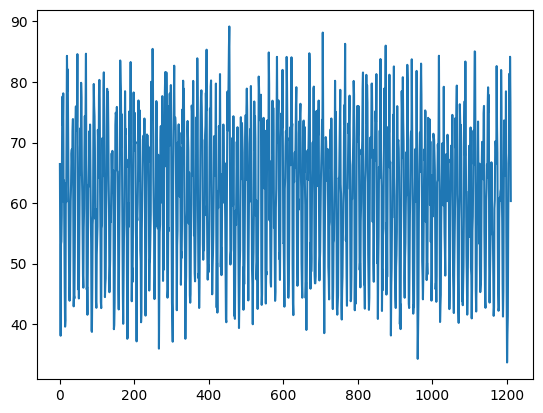

In [ ]:
rh = data['relhum']
rh.plot()

In [ ]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+24]]
    X.append(row)
    label = df_as_np[i+24]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 24
X, y = df_to_X_y(rh, WINDOW_SIZE)
X.shape, y.shape
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 24, 1), (780,), (120, 24, 1), (120,), (288, 24, 1), (288,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model4 = Sequential()
model4.add(InputLayer((24,1)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
25/25 [==============================] - 0s 11ms/step - loss: 38.4553 - root_mean_squared_error: 6.2012 - val_loss: 38.5792 - val_root_mean_squared_error: 6.2112
Epoch 2/20
25/25 [==============================] - 2s 102ms/step - loss: 38.6327 - root_mean_squared_error: 6.2155 - val_loss: 36.1512 - val_root_mean_squared_error: 6.0126
Epoch 3/20
25/25 [==============================] - 0s 12ms/step - loss: 37.4577 - root_mean_squared_error: 6.1203 - val_loss: 36.8089 - val_root_mean_squared_error: 6.0670
Epoch 4/20
25/25 [==============================] - 3s 139ms/step - loss: 37.5294 - root_mean_squared_error: 6.1261 - val_loss: 34.8881 - val_root_mean_squared_error: 5.9066
Epoch 5/20
25/25 [==============================] - 0s 10ms/step - loss: 34.4843 - root_mean_squared_error: 5.8723 - val_loss: 41.1871 - val_root_mean_squared_error: 6.4177
Epoch 6/20
25/25 [==============================] - 2s 103ms/step - loss: 35.7868 - root_mean_squared_error: 5.9822 - val_loss: 34.63

In [ ]:
from tensorflow.keras.models import load_model
model4 = load_model('model4/')
train_predictions = model4.predict(X_train).flatten()
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

25/25 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,70.391068,412.340546
1,70.277321,388.422424
2,70.271271,391.493195
3,70.251015,389.028595
4,70.278603,383.461395
...,...,...
775,70.454369,402.688751
776,70.336571,436.266693
777,70.174904,396.093994
778,70.045692,387.370911


In [ ]:
val_predictions = model4.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 0s 5ms/step


,Val Predictions,Actuals
0,55.102520,58.335743
1,48.931427,48.959263
2,45.302292,50.057137
3,48.423477,46.061413
4,55.701736,56.964539
...,...,...
115,73.958107,75.171219
116,71.531410,67.504730
117,70.333038,80.791138
118,74.102699,73.640419


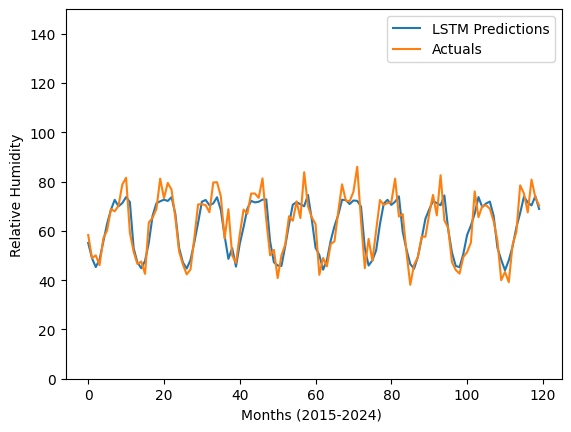

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('Relative Humidity')
plt.ylim(0, 150)
plt.legend()
plt.show()

In [ ]:
test_predictions = model4.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,57.548477,63.359856
1,50.679070,47.527554
2,45.284454,44.347691
3,46.537785,50.934708
4,57.335518,53.392937
...,...,...
283,72.364021,81.353539
284,72.628838,68.499481
285,71.042198,84.169983
286,74.583305,76.537987


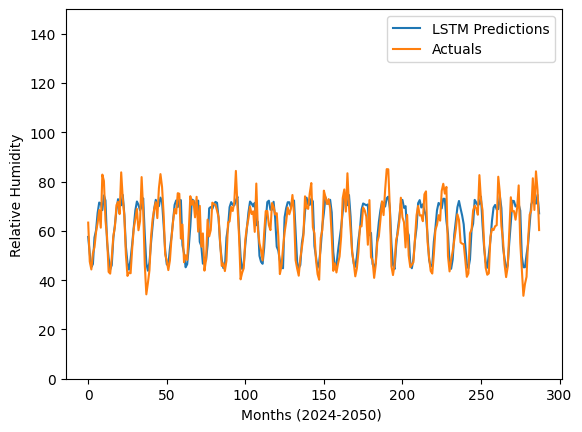

In [ ]:
plt.plot(test_results['Test Predictions'][:300], label='LSTM Predictions')
plt.plot(test_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2024-2050) ')
plt.ylabel('Relative Humidity')
plt.ylim(0, 150)
plt.legend()
plt.show()

In [ ]:
rh_list = val_predictions
rh_list = rh_list.tolist()
rh_list.extend(test_predictions)

print(len(rh_list))
rh_list

408


[55.10251998901367,
 48.931427001953125,
 45.30229187011719,
 48.42347717285156,
 55.70173645019531,
 62.968563079833984,
 68.55510711669922,
 72.6025390625,
 69.97203826904297,
 71.27176666259766,
 73.72623443603516,
 71.6973876953125,
 52.899574279785156,
 47.17870330810547,
 44.842384338378906,
 47.82390594482422,
 55.251853942871094,
 66.16372680664062,
 71.2138900756836,
 72.00724029541016,
 72.66072082519531,
 72.15814208984375,
 73.68546295166016,
 66.8659896850586,
 53.023468017578125,
 47.15240478515625,
 44.71294403076172,
 48.15566635131836,
 55.30804443359375,
 63.2315559387207,
 71.83756256103516,
 72.54196166992188,
 70.39911651611328,
 71.14432525634766,
 73.65572357177734,
 68.48934173583984,
 57.954463958740234,
 48.633636474609375,
 53.00007247924805,
 45.48681640625,
 54.73127746582031,
 61.49909973144531,
 68.9848403930664,
 72.16099548339844,
 71.55709075927734,
 71.82308197021484,
 72.6804428100586,
 72.76399230957031,
 55.77410888671875,
 47.27088928222656,
 45.9

<Axes: >

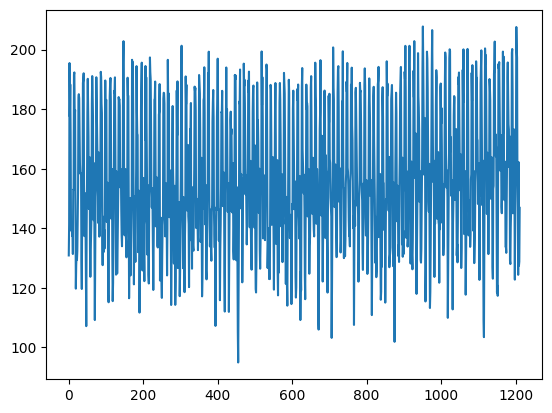

In [ ]:
pet = data['PET']
pet.plot()

In [ ]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+24]]
    X.append(row)
    label = df_as_np[i+24]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 24
X, y = df_to_X_y(pet, WINDOW_SIZE)
X.shape, y.shape
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 24, 1), (780,), (120, 24, 1), (120,), (288, 24, 1), (288,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model5 = Sequential()
model5.add(InputLayer((24,1)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0003), metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
25/25 [==============================] - 5s 148ms/step - loss: 120.1829 - root_mean_squared_error: 10.9628 - val_loss: 131.2091 - val_root_mean_squared_error: 11.4547
Epoch 2/20
25/25 [==============================] - 3s 116ms/step - loss: 117.5848 - root_mean_squared_error: 10.8437 - val_loss: 129.1283 - val_root_mean_squared_error: 11.3635
Epoch 3/20
25/25 [==============================] - 3s 118ms/step - loss: 116.3629 - root_mean_squared_error: 10.7872 - val_loss: 128.5671 - val_root_mean_squared_error: 11.3387
Epoch 4/20
25/25 [==============================] - 0s 11ms/step - loss: 116.0870 - root_mean_squared_error: 10.7744 - val_loss: 128.8743 - val_root_mean_squared_error: 11.3523
Epoch 5/20
25/25 [==============================] - 4s 187ms/step - loss: 115.3337 - root_mean_squared_error: 10.7394 - val_loss: 127.0063 - val_root_mean_squared_error: 11.2697
Epoch 6/20
25/25 [==============================] - 3s 121ms/step - loss: 114.6528 - root_mean_squared_error: 1

In [ ]:
from tensorflow.keras.models import load_model
model5 = load_model('model5/')
train_predictions = model5.predict(X_train).flatten()
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

25/25 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,137.116943,142.311585
1,154.227875,153.445940
2,182.290039,184.088281
3,185.766113,185.021185
4,185.495026,183.682287
...,...,...
775,140.031433,138.322915
776,145.702789,156.077954
777,142.941254,144.571217
778,134.048706,124.671602


In [ ]:
val_predictions = model5.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,138.031097,141.436018
1,156.528931,152.335834
2,184.478058,180.553289
3,184.306976,190.330052
4,185.585815,182.555008
...,...,...
115,139.035797,141.480421
116,143.606293,162.385227
117,144.539429,133.557070
118,129.821045,129.317306


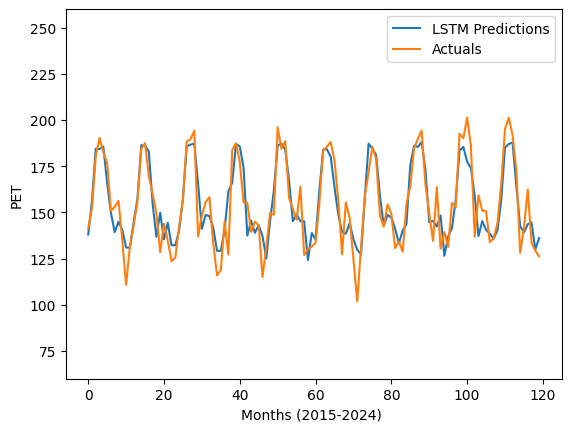

In [ ]:
plt.plot(val_results['Val Predictions'][:300],label='LSTM Predictions')
plt.plot(val_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2015-2024) ')
plt.ylabel('PET')
plt.ylim(60, 260)
plt.legend()
plt.show()

In [ ]:
test_predictions = model5.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

9/9 [==============================] - 0s 6ms/step


,Test Predictions,Actuals
0,141.607788,136.281220
1,155.978271,155.602925
2,185.132416,192.899875
3,187.014557,184.000569
4,187.178314,202.845311
...,...,...
283,145.540924,124.367533
284,130.037750,162.245475
285,144.566833,127.413064
286,127.209999,128.795589


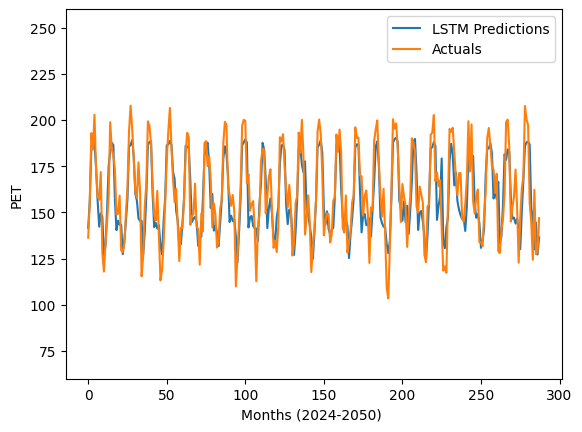

In [ ]:
plt.plot(test_results['Test Predictions'][:300], label='LSTM Predictions')
plt.plot(test_results['Actuals'][:300], label='Actuals')
plt.xlabel('Months (2024-2050) ')
plt.ylabel('PET')
plt.ylim(60, 260)
plt.legend()
plt.show()

In [ ]:
pet_list = val_predictions
pet_list = pet_list.tolist()
pet_list.extend(test_predictions)

print(len(pet_list))
pet_list

408


[138.03109741210938,
 156.5289306640625,
 184.47805786132812,
 184.30697631835938,
 185.5858154296875,
 165.97393798828125,
 149.73324584960938,
 139.31884765625,
 144.94305419921875,
 140.45587158203125,
 131.03213500976562,
 130.8441162109375,
 144.64633178710938,
 157.5438232421875,
 186.32162475585938,
 186.2454833984375,
 182.97344970703125,
 154.73947143554688,
 136.74310302734375,
 149.8416748046875,
 135.42608642578125,
 144.38482666015625,
 132.21298217773438,
 132.25802612304688,
 140.30838012695312,
 157.48907470703125,
 185.83596801757812,
 186.65359497070312,
 187.25,
 165.482421875,
 141.16891479492188,
 148.61459350585938,
 147.97775268554688,
 141.66787719726562,
 129.16761779785156,
 129.21243286132812,
 140.5789794921875,
 161.4766845703125,
 165.98629760742188,
 186.83822631835938,
 185.7236328125,
 174.2451171875,
 137.46066284179688,
 145.55288696289062,
 138.93084716796875,
 143.01748657226562,
 137.25677490234375,
 125.10763549804688,
 145.35903930664062,
 161.83

<Axes: >

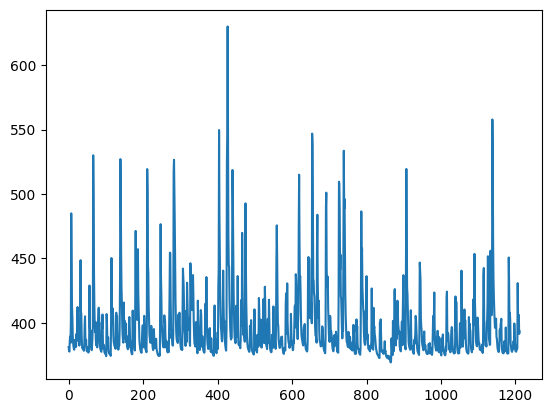

In [ ]:
sm = data['soilmoist']
sm.plot()

In [ ]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+24]]
    X.append(row)
    label = df_as_np[i+24]
    y.append(label)
  return np.array(X), np.array(y)
WINDOW_SIZE = 24
X, y = df_to_X_y(sm, WINDOW_SIZE)
X.shape, y.shape
X_train, y_train = X[:780], y[:780]
X_val, y_val = X[780:900], y[780:900]
X_test, y_test = X[900:],y[900:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((780, 24, 1), (780,), (120, 24, 1), (120,), (288, 24, 1), (288,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model6 = Sequential()
model6.add(InputLayer((24,1)))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0), metrics=[RootMeanSquaredError()])

In [ ]:
model6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
25/25 [==============================] - 7s 214ms/step - loss: 1075.0455 - root_mean_squared_error: 32.7879 - val_loss: 533.6110 - val_root_mean_squared_error: 23.1000
Epoch 2/20
25/25 [==============================] - 0s 11ms/step - loss: 1019.8064 - root_mean_squared_error: 31.9344 - val_loss: 562.4341 - val_root_mean_squared_error: 23.7157
Epoch 3/20
25/25 [==============================] - 0s 11ms/step - loss: 1005.2318 - root_mean_squared_error: 31.7054 - val_loss: 621.1611 - val_root_mean_squared_error: 24.9231
Epoch 4/20
25/25 [==============================] - 3s 136ms/step - loss: 1009.0588 - root_mean_squared_error: 31.7657 - val_loss: 458.8158 - val_root_mean_squared_error: 21.4200
Epoch 5/20
25/25 [==============================] - 0s 18ms/step - loss: 1000.9297 - root_mean_squared_error: 31.6375 - val_loss: 555.3616 - val_root_mean_squared_error: 23.5661
Epoch 6/20
25/25 [==============================] - 0s 12ms/step - loss: 1002.3038 - root_mean_squared_error

In [ ]:
from tensorflow.keras.models import load_model
model6 = load_model('model6/')
train_predictions = model6.predict(X_train).flatten()
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

25/25 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,386.701538,412.340546
1,386.701538,388.422424
2,386.701538,391.493195
3,386.701538,389.028595
4,386.701538,383.461395
...,...,...
775,386.701538,402.688751
776,386.701538,436.266693
777,386.701538,396.093994
778,386.701538,387.370911


In [ ]:
val_predictions = model6.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,404.307068,383.261505
1,404.307068,380.672089
2,404.307068,379.492310
3,404.307068,382.247009
4,404.307068,379.727509
...,...,...
115,404.307068,409.865265
116,404.307068,389.895599
117,404.307068,383.026154
118,404.307068,380.224792


In [ ]:
import pandas as pd

# Create a dictionary for DataFrame construction
data1 = {'rh': rh_list, 'PET': pet_list}

# Create the DataFrame
df1 = pd.DataFrame(data1)

# Convert the DataFrame to a CSV file
df1.to_csv('future_projected_data_2.csv', index=False)

In [ ]:
pet_list.__len__()

408

In [ ]:
df1

,rh,PET
0,55.102520,138.031097
1,48.931427,156.528931
2,45.302292,184.478058
3,48.423477,184.306976
4,55.701736,185.585815
...,...,...
403,72.364021,145.540924
404,72.628838,130.037750
405,71.042198,144.566833
406,74.583305,127.209999
